# Combine hand annotations
Hand annotations for the age protected attribute were made by 4 different people. Some of the annotations may overlap or we might have different opinions. This notebook combines and merges the annotations in a single annotations file.

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
RES_DIR = '../res'

%cd {RES_DIR}

In [3]:
files = [
    'annotations/annotations_person0.csv',
    'annotations/annotations_person1.csv',
    'annotations/annotations_person2.csv',
    'annotations/annotations_person3.csv',
]

The format of the annotation files is

```csv
id,label
12,old
345,young
678,none
901,old
```

In [4]:
dfs = []
for i, file in enumerate(files):
    try:
        df = pd.read_csv(file, index_col='id')
    except FileNotFoundError:
        df = pd.DataFrame(columns=['label'])
    df = df.rename(columns={'label': f'person{i}'})
    dfs.append(df)

In [5]:
df = dfs[0].join(dfs[1:], how='outer')
df

person0 person1 person2 person3
id                                    
192        old     NaN     NaN     NaN
241        old     NaN     NaN     NaN
294        old     NaN     NaN     NaN
328      young     NaN     NaN     NaN
338        old     NaN     NaN     NaN
...        ...     ...     ...     ...
580986     NaN    none     NaN     NaN
581040     old     NaN     NaN     NaN
581496     NaN     old     NaN     NaN
581736     NaN   young     NaN     NaN
581886     NaN    none     NaN     NaN

[8490 rows x 4 columns]

In [6]:
def add_counts(row):
    counts = row.value_counts()
    row['count_young'] = counts.get('young',0)
    row['count_old'] = counts.get('old',0)
    row['count_none'] = counts.get('none',0)
    row['annot'] = row['count_young'] + row['count_old'] + row['count_none']
    return row
    
df = df.apply(add_counts, axis=1)
df

person0 person1 person2 person3  count_young  count_old  count_none  \
id                                                                           
192        old     NaN     NaN     NaN            0          1           0   
241        old     NaN     NaN     NaN            0          1           0   
294        old     NaN     NaN     NaN            0          1           0   
328      young     NaN     NaN     NaN            1          0           0   
338        old     NaN     NaN     NaN            0          1           0   
...        ...     ...     ...     ...          ...        ...         ...   
580986     NaN    none     NaN     NaN            0          0           1   
581040     old     NaN     NaN     NaN            0          1           0   
581496     NaN     old     NaN     NaN            0          1           0   
581736     NaN   young     NaN     NaN            1          0           0   
581886     NaN    none     NaN     NaN            0          0           1   

        annot  
id             
192         1  
241         1  
294         1  
328         1  
338         1  
...       ...  
580986      1  
581040      1  
581496      1  
581736      1  
581886      1  

[8490 rows x 8 columns]

## Merging criteria
We defined a simple criteria for merging different annotations of a single image. We applied that criteria to define a combined label for each image.

In [7]:
# yyyy-y
# yyyo-y
# yyoo-x
# yyyn-y
# yyon-y
# yynn-y
# yonn-x
# ynnn-x
# nnnn-x

# yyy-y
# yyo-y
# yyn-y
# yon-x
# ynn-x
# nnn-x

# yy-y
# yo-x
# yn-y
# nn-x

# y-y
# n-x


# 4vs0: win
# 3vs1: win
# 2vs2: drop

# 3vs0: win
# 2vs1: win (#?)

# 2vs0: win
# 1vs1: drop

# 1vs0: win


def combine_labels(row):
    if row.count_none > row.annot / 2:
        label = np.nan  # remove
    elif row.count_young == row.count_old:
        label = np.nan  # remove
    elif row.count_young > row.count_old:
        label = 'young'
    else:
        label = 'old'
    row['label'] = label
    return row

df = df.apply(combine_labels, axis=1)
df

person0 person1 person2 person3  count_young  count_old  count_none  \
id                                                                           
192        old     NaN     NaN     NaN            0          1           0   
241        old     NaN     NaN     NaN            0          1           0   
294        old     NaN     NaN     NaN            0          1           0   
328      young     NaN     NaN     NaN            1          0           0   
338        old     NaN     NaN     NaN            0          1           0   
...        ...     ...     ...     ...          ...        ...         ...   
580986     NaN    none     NaN     NaN            0          0           1   
581040     old     NaN     NaN     NaN            0          1           0   
581496     NaN     old     NaN     NaN            0          1           0   
581736     NaN   young     NaN     NaN            1          0           0   
581886     NaN    none     NaN     NaN            0          0           1   

        annot  label  
id                    
192         1    old  
241         1    old  
294         1    old  
328         1  young  
338         1    old  
...       ...    ...  
580986      1    NaN  
581040      1    old  
581496      1    old  
581736      1  young  
581886      1    NaN  

[8490 rows x 9 columns]

In [8]:
print('df len:', len(df))
print('nan labels:', sum(df.label.isna()))
df.label.value_counts()

df len: 8490
nan labels: 1452


old      4603
young    2435
Name: label, dtype: int64

In [9]:
df_merged = df.label.to_frame().dropna()
df_merged

label
id           
192       old
241       old
294       old
328     young
338       old
...       ...
580613    old
580847  young
581040    old
581496    old
581736  young

[7038 rows x 1 columns]

## Save merged annotations file

In [10]:
DST = 'annotations/annotations_merged.csv'

if not os.path.exists(os.path.dirname(DST)):
    os.makedirs(os.path.dirname(DST))

# df_merged.to_csv(DST, index_label='id')

# Analysis
This section provides a simple analysis of the distribution of the hand annotations:
- how balanced the dataset itself is.
- agreement between annotators in the image label
- bias of each person
- size of olverlapping set (images with annotations from more than one person)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

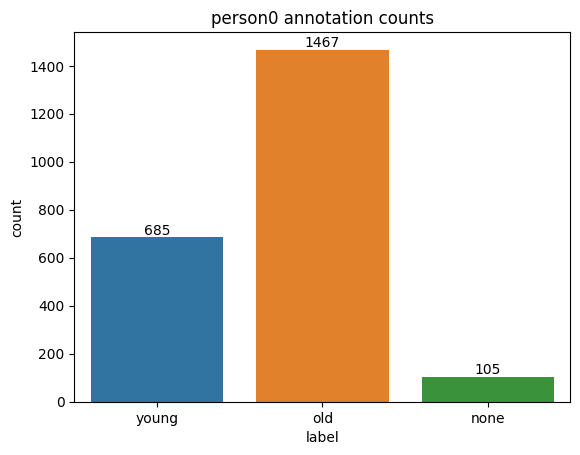

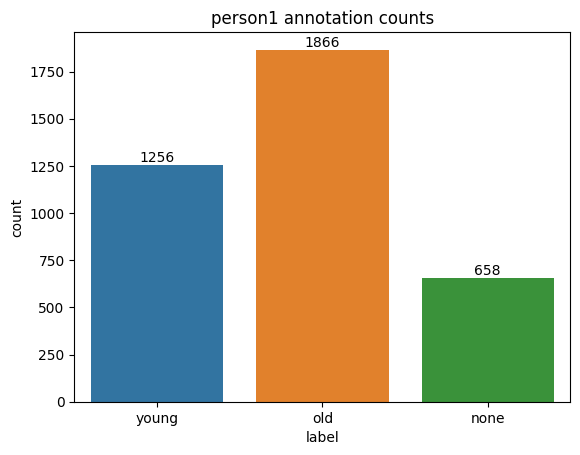

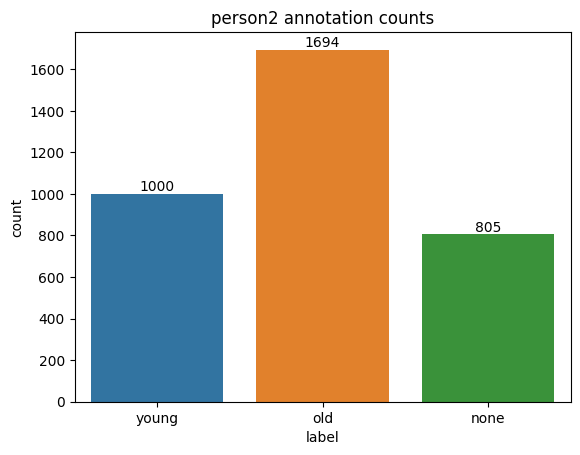

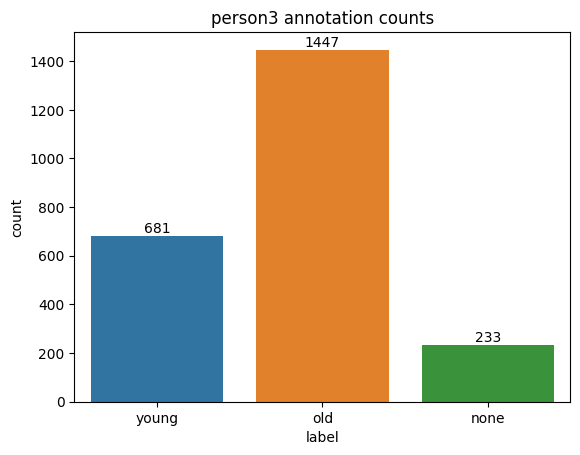

In [12]:
data = df.label.value_counts()

for n in range(4):
    person = f'person{n}'
    ax = sns.countplot(df, x=person, order=['young', 'old', 'none'])
    ax.bar_label(ax.containers[0])
    ax.set(title=f'{person} annotation counts', xlabel='label')
    plt.show()

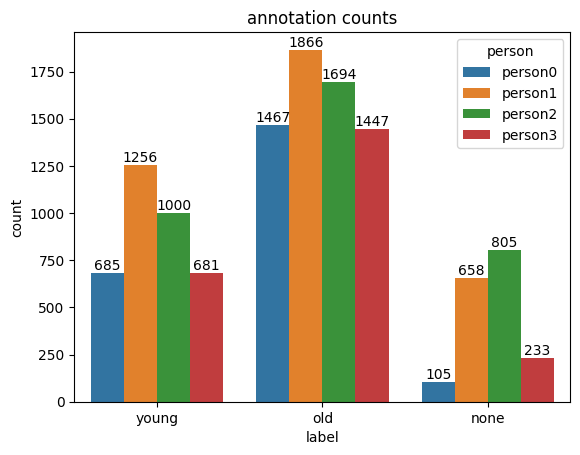

In [13]:
df_authors = pd.DataFrame(columns=['label', 'person'])

for n in range(4):
    person = f'person{n}'
    frame = df.drop(columns=['label']).rename(columns={person: 'label'})['label'].to_frame()
    frame['person'] = person
    df_authors = df_authors.append(frame, ignore_index=True)

ax = sns.countplot(df_authors, x='label', hue='person', order=['young', 'old', 'none'])
for n in range(4):
    ax.bar_label(ax.containers[n])
ax.set(title=f'annotation counts')
plt.show()

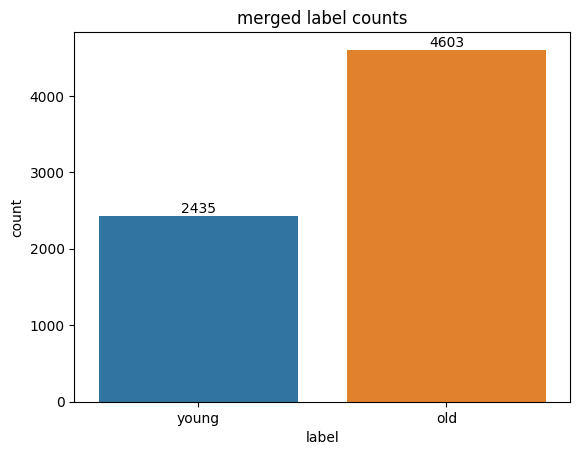

old      4603
young    2435
Name: label, dtype: int64

In [14]:
data = df.label.value_counts()

ax = sns.countplot(df, x='label', order=['young', 'old'])
ax.bar_label(ax.containers[0])
ax.set(title='merged label counts')
plt.show()

data

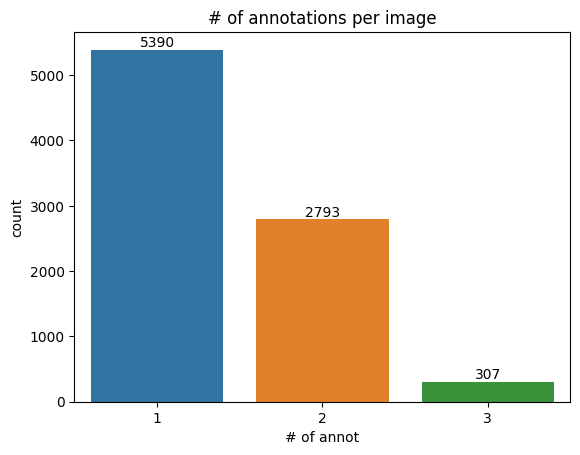

1    5390
2    2793
3     307
Name: annot, dtype: int64

In [15]:
data = df.annot.value_counts()

ax = sns.countplot(df, x='annot')
ax.bar_label(ax.containers[0])
ax.set(title='# of annotations per image', xlabel='# of annot')
plt.show()

data

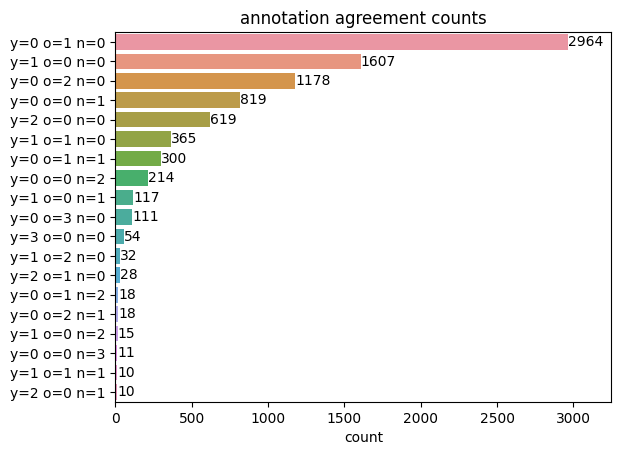

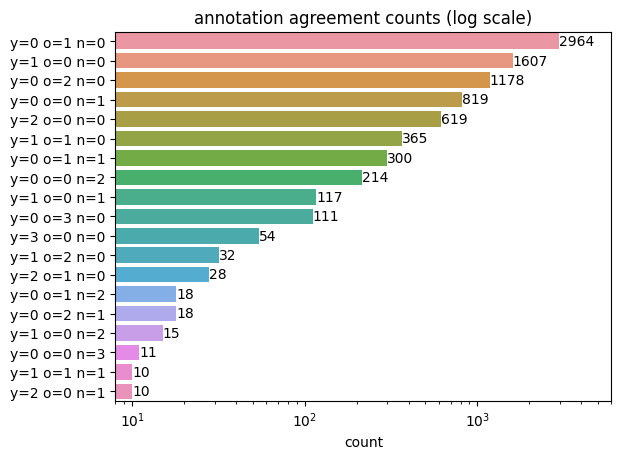

y=0 o=1 n=0    2964
y=1 o=0 n=0    1607
y=0 o=2 n=0    1178
y=0 o=0 n=1     819
y=2 o=0 n=0     619
y=1 o=1 n=0     365
y=0 o=1 n=1     300
y=0 o=0 n=2     214
y=1 o=0 n=1     117
y=0 o=3 n=0     111
y=3 o=0 n=0      54
y=1 o=2 n=0      32
y=2 o=1 n=0      28
y=0 o=1 n=2      18
y=0 o=2 n=1      18
y=1 o=0 n=2      15
y=0 o=0 n=3      11
y=1 o=1 n=1      10
y=2 o=0 n=1      10
dtype: int64

In [16]:
data = df.apply(lambda row: f'y={row.count_young} o={row.count_old} n={row.count_none}', axis=1).value_counts()

ax = sns.barplot(y=data.index, x=data.values)
ax.bar_label(ax.containers[0])
ax.set(title='annotation agreement counts', xlabel='count', xlim=(0, 3250))
plt.show()

ax = sns.barplot(y=data.index, x=data.values, log='x')
ax.bar_label(ax.containers[0])
ax.set(title='annotation agreement counts (log scale)', xlabel='count', xlim=(8, 6000))
plt.show()

data

# Image visualization
In this section we show some of the images we all agreed on.

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as img

In [18]:
IMG_DATASET_DIR = 'reduced_coco_10780'

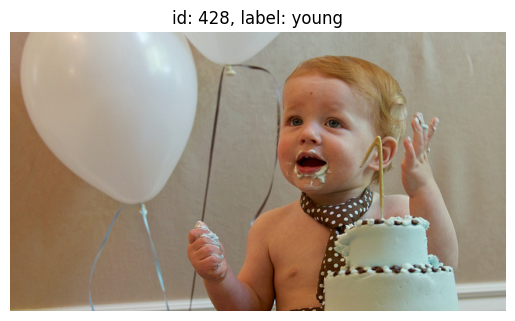

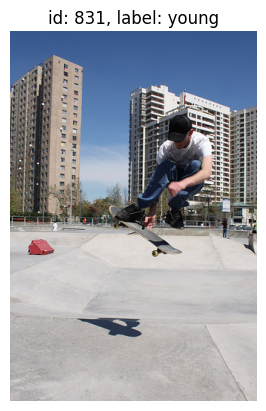

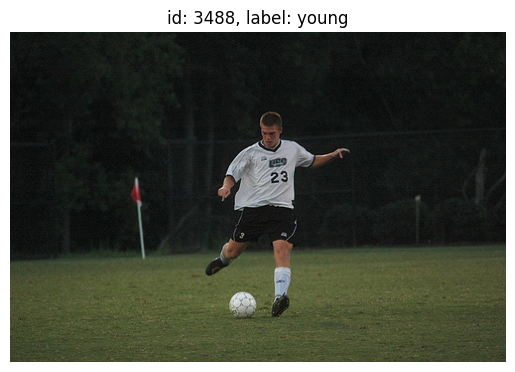

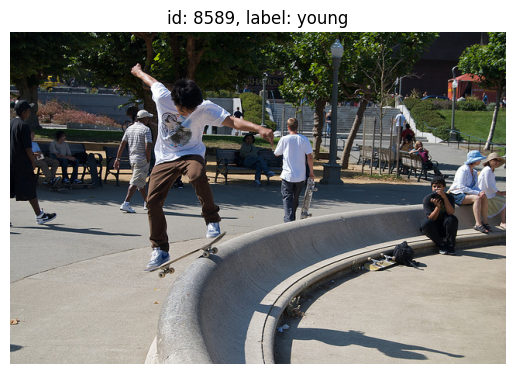

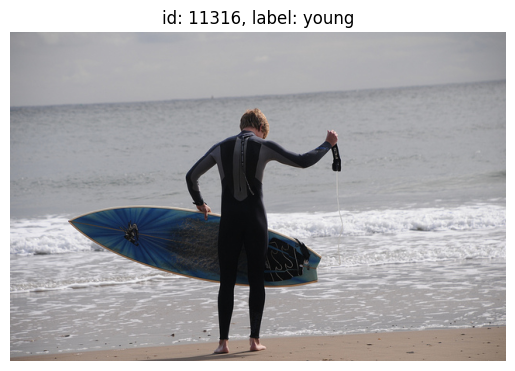

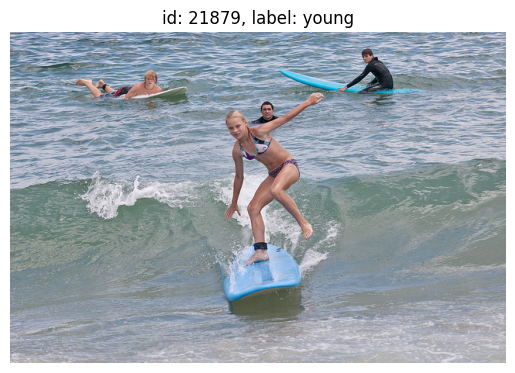

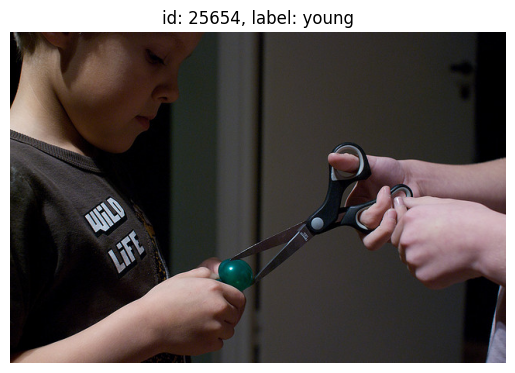

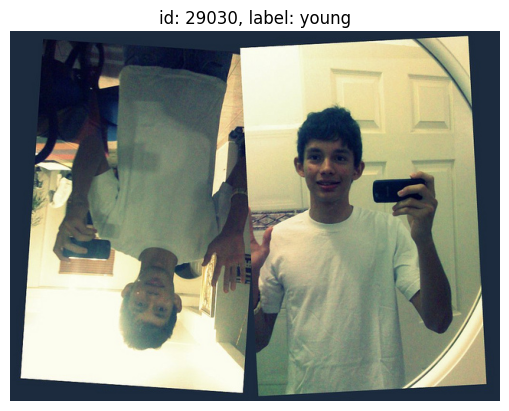

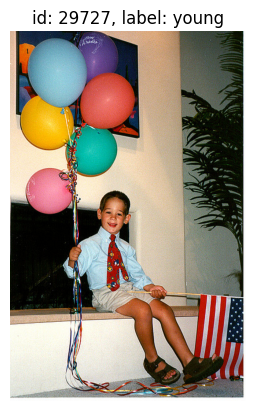

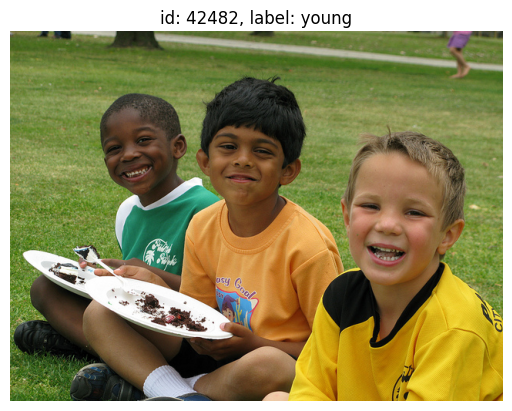

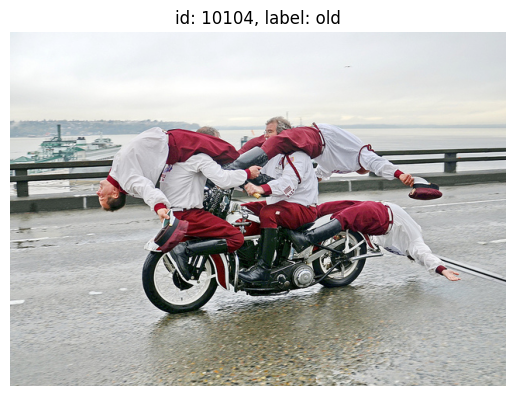

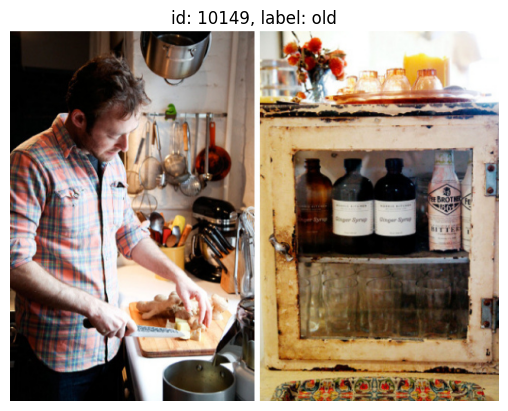

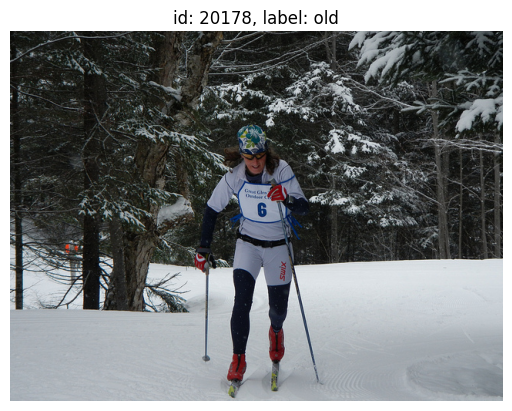

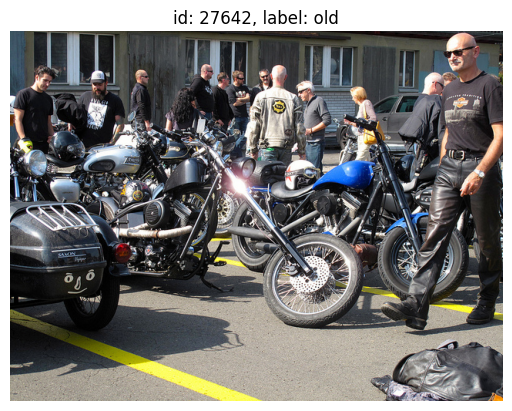

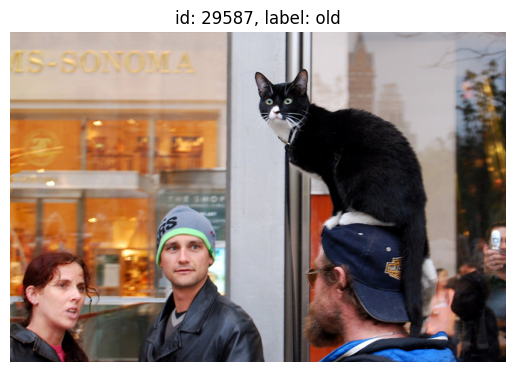

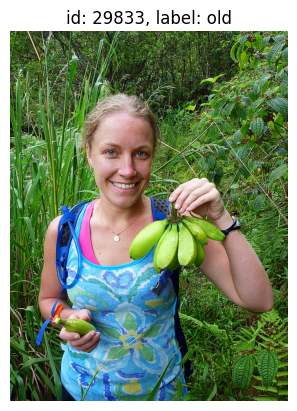

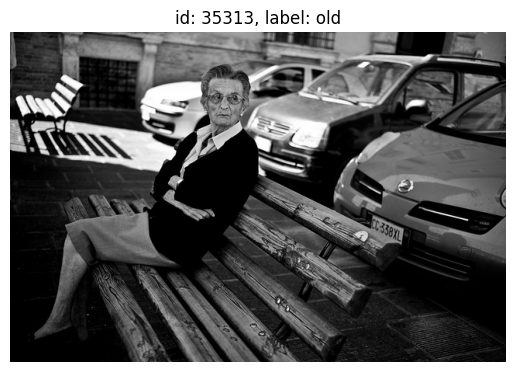

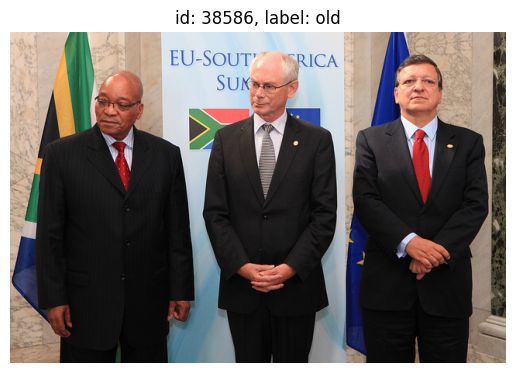

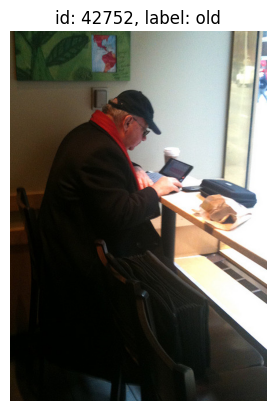

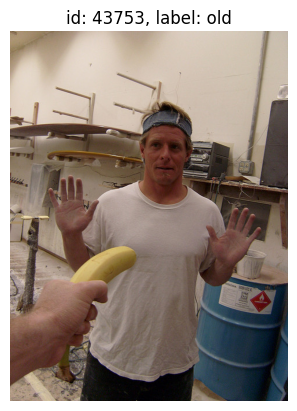

In [19]:
for n in df[df.count_young==3].iloc[0:10].index:
    path = f'{IMG_DATASET_DIR}/{n:012}.jpg'
    im = img.imread(path)
    plt.imshow(im)
    plt.title(f'id: {n}, label: young')
    plt.axis('off')
    plt.show()

for n in df[df.count_old==3].iloc[0:10].index:
    path = f'{IMG_DATASET_DIR}/{n:012}.jpg'
    im = img.imread(path)
    plt.imshow(im)
    plt.title(f'id: {n}, label: old')
    plt.axis('off')
    plt.show()